# Stacking of models into two layers
1. First layer: train models on the whole training set
2. Second layer: train a model on the first layer's predictions and the rest of the training set

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
import pandas as pd

from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

## Configure running

In [ ]:
load_xgb: bool = True
load_lgb: bool = True
load_cat: bool = True
load_rf:  bool = False
load_svr: bool = True

## Get the data

In [ ]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

## Train test split for the base layer and meta layer

In [ ]:
# The base layer gets 80% of the data
# The meta layer gets 20% of the data
base_to_meta_layer_split = 0.8

base_x_train = x_whole.sample(frac=base_to_meta_layer_split)
meta_x_train = x_whole.sample(frac=1-base_to_meta_layer_split)

# Get the corresponding y values
base_y_train = y_whole[base_x_train.index]
meta_y_train = y_whole[meta_x_train.index]
base_x_train.columns

# Train Base level models
It is important to use a variety of models to get a diverse set of predictions.

I want a model to check if there is a linear relationship between the location features and the target. I will use a linear regression model for this.
I want to check if the different irradiation values are correlated with the target. I will use xgboost for this.
I want to check if the different temperature values are correlated with the target. I will use 


## XGBoost
The XGBoost model is a gradient boosting model. It is a tree based model that uses the gradient descent algorithm to minimize the loss function. The loss function is a combination of the training loss and a regularization term. The regularization term is used to prevent overfitting. The model is trained on the training set and the validation set is used to check if the model is overfitting. The model is then trained on the whole training set and the test set is used to check the model's performance.

Utilizing k-fold cross validation to train the model on different subsets of the training set and validate on the rest of the training set. This is done to prevent overfitting.

In [ ]:
# K-fold cross validation
if not load_xgb:
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    xgboost_models = []


    for train_index, test_index in kf.split(base_x_train):
        reg = xgb.XGBRegressor(n_estimators=10000000,
                        early_stopping_rounds=50,
                        learning_rate= 0.001,
                        objective="reg:linear",
                        eval_metric="mae",
                        sub_sample = 0.9,
                        colsample_bytree = 1.0,
                        gamma = 0,
                        min_child_weight=0,
                        max_depth=9)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Create sample weights for training data
        sample_weight_train = np.where(X_train['time_since_prediction'] == 0, 1, 2)
        # Create sample weights for testing data
        sample_weight_test = np.where(X_test['time_since_prediction'] == 0, 1, 2)
        
        reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                sample_weight=sample_weight_train,
                sample_weight_eval_set=[sample_weight_test],  # Here's how you pass the eval weights
                verbose=100)
        
        xgboost_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions, sample_weight=sample_weight_test)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

## Catboost

In [ ]:
if not load_cat:
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0
    catboost_models = []

    def compute_sample_weight(data):
        # Assign weight of 2 for estimated data and 1 for observed data
        return np.where(data['time_since_prediction'] > 0, 2, 1)

    for train_index, test_index in kf.split(base_x_train):
        reg = CatBoostRegressor(
            iterations=10000000,
            depth=8,
            learning_rate=0.001,
            loss_function='MAE',
            verbose=200
        )
        
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Compute sample weights for training and testing data
        train_weight = compute_sample_weight(X_train)
        test_weight = compute_sample_weight(X_test)

        # Create Pool for training and testing
        train_pool = Pool(data=X_train, label=y_train, weight=train_weight)
        test_pool = Pool(data=X_test, label=y_test, weight=test_weight)

        # Fit the model using the sample weights
        reg.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

        catboost_models.append(reg)
        predictions = reg.predict(test_pool)
        
        # Compute weighted MAE manually
        weighted_mae = np.sum(test_weight * np.abs(y_test - predictions)) / np.sum(test_weight)
        total_mae += weighted_mae
        
        print(f"Fold {len(catboost_models)}, Weighted Mean Absolute Error: {weighted_mae}")

    average_mae = total_mae / num_folds
    print(f"Average Weighted Mean Absolute Error: {average_mae}")


## lightgbm

In [ ]:
if not load_lgb:
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    total_mae = 0

    lightgbm_models = []

    params = {
        'objective': 'regression_l1',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'metric': 'mae',
        'num_leaves': 128,
        'learning_rate': 0.001,
        'feature_fraction': 1.0,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'min_data_in_leaf': 20,
        'early_stopping_rounds': 100,
        'verbosity': -1,  # 0 for verbose, -1 for silent
    }

    num_round = 10000000 # number of training iterations

    # Ensure column names are compatible with LightGBM
    base_x_train.columns = base_x_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

    for train_index, test_index in kf.split(base_x_train):
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test)

        reg = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
        lightgbm_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

## Random Forest
Simple random forest

In [ ]:
# if not load_rf:
#     # K-fold cross validation
#     num_folds = 5
#     kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#     total_mae = 0

#     random_forest_models = []


#     for train_index, test_index in kf.split(base_x_train):

#         rf_model = RandomForestRegressor(n_estimators=200, max_depth=25, random_state=42)

#         X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
#         y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

#         # Train the Random Forest model on the cleaned training data
        
#         rf_model.fit(X_train, y_train)
        
#         random_forest_models.append(rf_model)
#         predictions = rf_model.predict(X_test)
        
#         mae = mean_absolute_error(y_test, predictions)
#         total_mae += mae
        
#         print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

#     average_mse = total_mae / num_folds
#     print(f"Average Mean Squared Error: {average_mse}")

## Swarm Vector Regression

In [ ]:
# if not load_svr:
#     # K-fold cross validation
#     num_folds = 5
#     kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#     total_mae = 0
#     svr_models = []

#     for train_index, test_index in kf.split(base_x_train):
#         # Train an SVR model
#         svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

#         X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
#         y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

#         # Train the Swarm Vector Regression model on the cleaned training data
#         svr.fit(X_train, y_train)

#         svr_models.append(svr)
#         predictions = rf_model.predict(X_test)
        
#         mae = mean_absolute_error(y_test, predictions)
#         total_mae += mae
        
#         print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

#     average_mse = total_mae / num_folds
#     print(f"Average Mean Squared Error: {average_mse}")



### load the models and save the newly trained models

In [ ]:
# Check what models should be loaded
# Load XGBoost models
if load_xgb:
    with open("xgboost_models_stack.pkl", "rb") as file:
        xgboost_models = pickle.load(file)
        print(f"[LOADED] xgboost_models {len(xgboost_models)} has successfully been loaded")
else:
    with open("xgboost_models_stack.pkl", "wb") as file:
        pickle.dump(xgboost_models, file)
        print(f"[SAVED] xgboost_models has successfully been saved.")

# Load CatBoost models
if load_cat:
    with open("catboost_models_stack.pkl", "rb") as file:
        catboost_models = pickle.load(file)
        print(f"[LOADED] catboost_models {len(catboost_models)} has successfully been loaded")
else:
    with open("catboost_models_stack.pkl", "wb") as file:
        pickle.dump(catboost_models, file)
        print(f"[SAVED] catboost_models has successfully been saved.")

# Load lightGBM models
if load_lgb:
    with open("lightgbm_models_stack.pkl", "rb") as file:
        lightgbm_models = pickle.load(file)
        print(f"[LOADED] lightgbm_models {len(lightgbm_models)} has successfully been loaded")
else:
    with open("lightgbm_models_stack.pkl", "wb") as file:
        pickle.dump(lightgbm_models, file)
        print(f"[SAVED] lightgbm_models has successfully been saved.")

# # Load random forest models
# if load_rf:
#     with open("random_forest_models_stack.pkl", "rb") as file:
#         random_forest_models = pickle.load(file)
#         print(f"[LOADED] random_forest_models {len(random_forest_models)} has successfully been loaded")
# else:
#     with open("random_forest_models_stack.pkl", "wb") as file:
#         pickle.dump(random_forest_models, file)
#         print(f"[SAVED] random_forest_models has successfully been saved.")

# # Load SVR models
# if load_svr:
#     with open("svr_models_stack.pkl", "rb") as file:
#         svr_models = pickle.load(file)
#         print(f"[LOADED] svr_models {len(svr_models)} has successfully been loaded")
# else:
#     with open("svr_models_stack.pkl", "wb") as file:
#         pickle.dump(svr_models, file)
#         print(f"[SAVED] svr_models has successfully been saved.")


In [ ]:
def average_prediction(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


# Train meta learner model

Create dataset for meta learner model by using models to predict on the meta layer training set

In [ ]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(meta_x_train, xgboost_models)
base_catboost_predictions = average_prediction(meta_x_train, catboost_models)
base_lightgbm_predictions = average_prediction(meta_x_train, lightgbm_models)
# base_random_forest_predictions = average_prediction(meta_x_train, random_forest_models)
# base_swarm_vector_regression_predictions = average_prediction(meta_x_train, svr_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions
# meta_base_x_train["random_forest"] = base_random_forest_predictions
# meta_base_x_train["swarm_vector_regression"] = base_swarm_vector_regression_predictions


Train meta learner model on new dataset

In [ ]:
# K-fold cross validation

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

meta_models = []


for train_index, test_index in kf.split(meta_base_x_train):

    reg = xgb.XGBRegressor(n_estimators=100000,
                       early_stopping_rounds=50,
                       learning_rate= 0.01,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       alpha = 0.001,
                       min_child_weight=0,
                       max_depth=4)

    X_train, X_test = meta_base_x_train.iloc[train_index], meta_base_x_train.iloc[test_index]
    y_train, y_test = meta_y_train.iloc[train_index], meta_y_train.iloc[test_index]

    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)
    
    meta_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
y_pred_val_obs_combined = average_prediction(X_val_obs_combined, meta_models)
y_pred_val_est_combined = average_prediction(X_val_est_combined, meta_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


## Get predictions for meta learner model test set

In [ ]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(x_test_whole, xgboost_models)
base_catboost_predictions = average_prediction(x_test_whole, catboost_models)
base_lightgbm_predictions = average_prediction(x_test_whole, lightgbm_models)
base_random_forest_predictions = average_prediction(x_test_whole, random_forest_models)
base_swarm_vector_regression_predictions = average_prediction(x_test_whole, svr_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions
meta_base_x_train["random_forest"] = base_random_forest_predictions
meta_base_x_train["swarm_vector_regression"] = base_swarm_vector_regression_predictions

In [ ]:
# Predict on the cleaned validation set
y_predictions = average_prediction(meta_base_x_train, meta_models)

## Save predictions

In [ ]:
from src.models.saving import save_predictions
from src.features.postprocess_data import postprocess_data
y_predictions = postprocess_data(x_test_whole, pd.Series(y_predictions))
submission_name = 'stacking with xgboost catboost lightgbm random_forest svr '
save_predictions(y_predictions, submission_name)

## Visualize predictions vs best model predictions

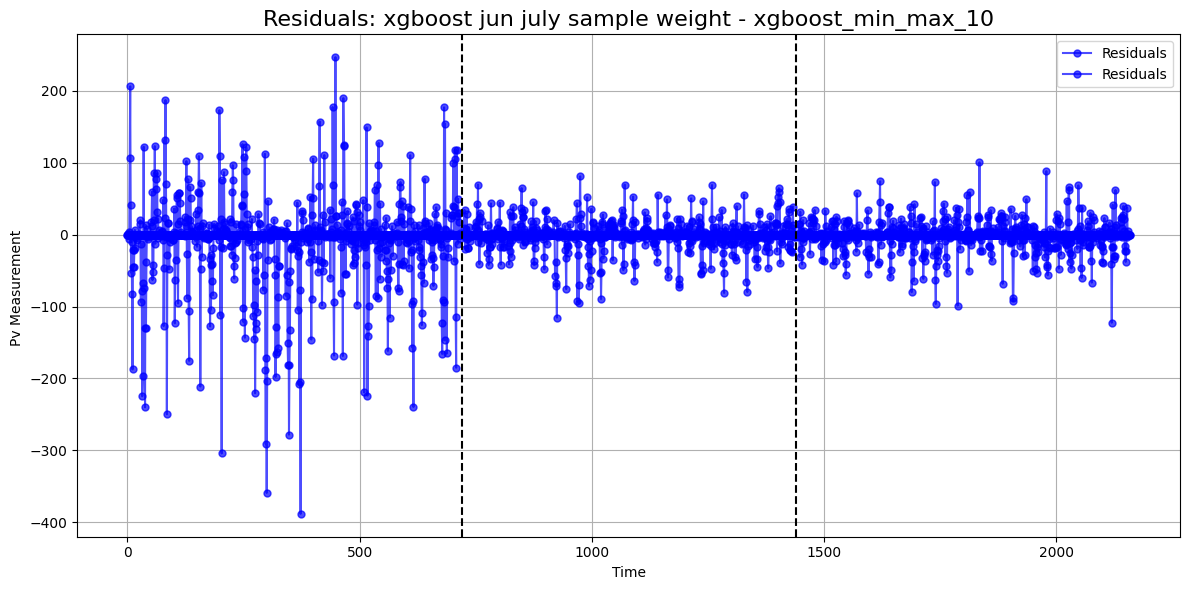

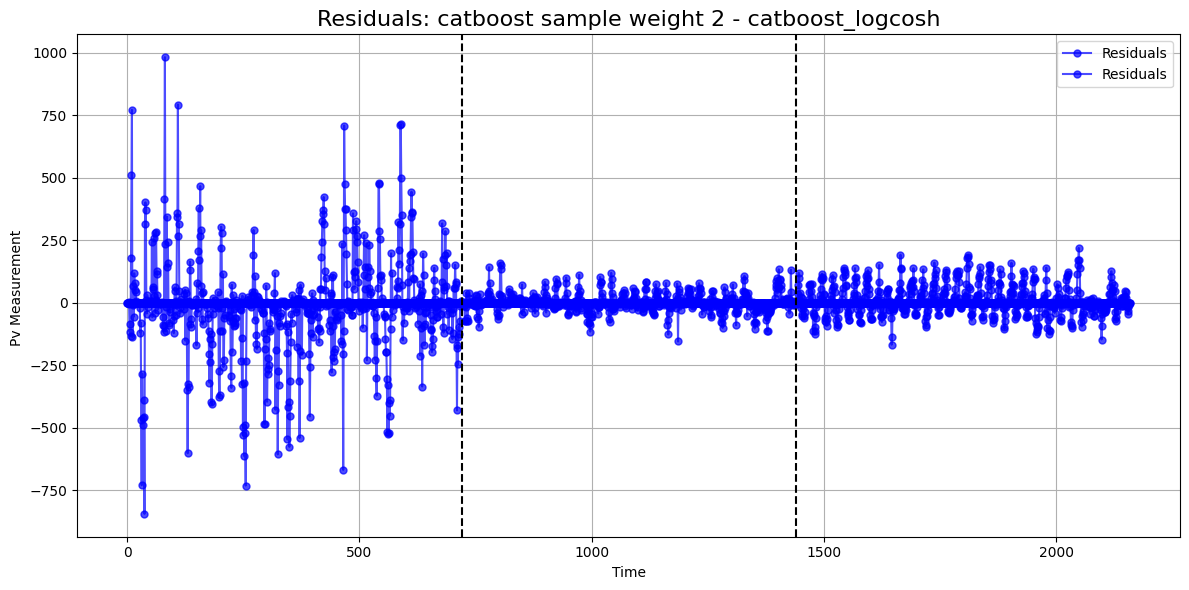

In [10]:
from src.visualization.plotting import plot_residual_predictions
# plot_residual_predictions("stack + 149", submission_name)
plot_residual_predictions("xgboost jun july sample weight", "xgboost_min_max_10")
# plot_residual_predictions("stacking test1", "xgboost_min_max_10")
# plot_residual_predictions("stacking test1", "catboost_2")
# plot_residual_predictions("xgboost_min_max_10", "catboost_2")
# plot_residual_predictions("xgboost_min_max_10", "ny_catboost_3_modeller_5")
# plot_residual_predictions("catboost_2", "ny_catboost_3_modeller_5")

# plot_residual_predictions("04 xgboost 149 033 stack 150 027 cat150", "catboost_logcosh")
plot_residual_predictions("catboost sample weight 2", "catboost_logcosh")



# plot_residual_predictions("stack  149 avg", "average xg cat stack")

